
🔍 Lasso Regression Evaluation Metrics:
MAE:  51.23
MSE:  6385.96
RMSE: 79.91
R²:   0.58


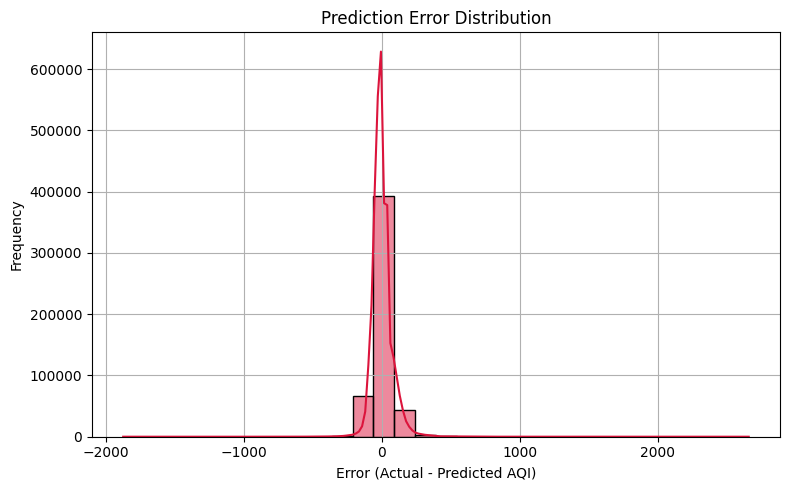


✅ Lasso model and preprocessing pipeline saved as 'lasso_model.pkl' and 'preprocessing_pipeline.pkl'


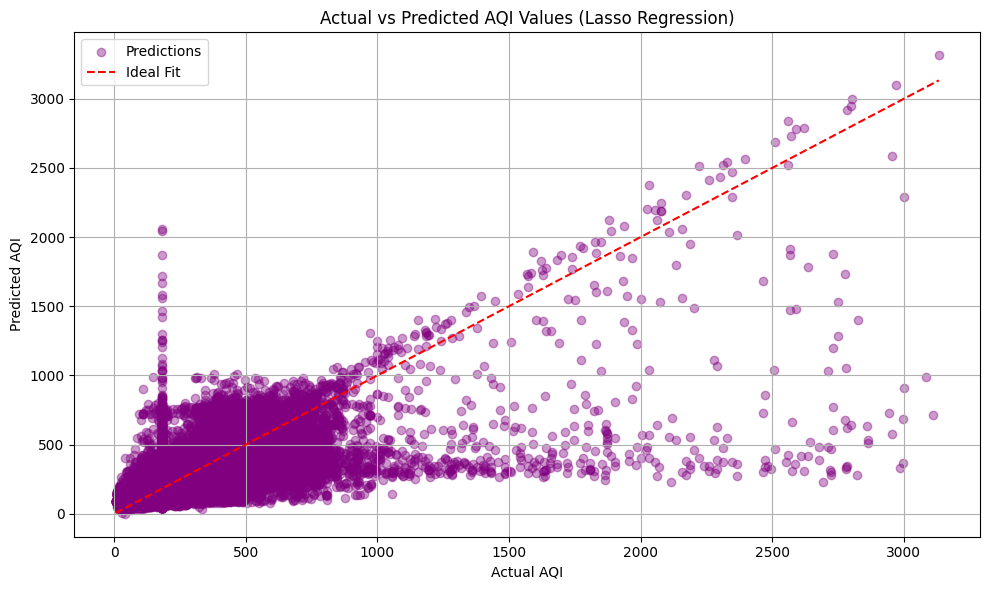

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load the dataset
df = pd.read_csv('../data_clean/filtered_dataset.csv')  # Update the path if needed

# Target column
target_column = 'AQI'

# Step 1: Feature Engineering on Date and Time
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.hour
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday

# Drop original 'Date' and 'Time'
df.drop(columns=['Date', 'Time'], inplace=True)

# Step 2: One-Hot Encoding for AQI_bucket
df = pd.get_dummies(df, columns=['AQI_Bucket'], drop_first=True)

# Step 3: Split Features and Target
X = df.drop(columns=[target_column])
y = df[target_column]

# Step 4: Define categorical and numerical columns
categorical_cols = ['City']  # Add any other categorical columns if needed
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

# Step 5: Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y if y.nunique() < 2 else None
)

# Step 7: Apply transformations
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Step 8: Train the Lasso model
lasso_model = Lasso(alpha=0.1)  # You can adjust alpha (regularization strength)
lasso_model.fit(X_train, y_train)

# Step 9: Make Predictions
y_pred = lasso_model.predict(X_test)

# Step 10: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n🔍 Lasso Regression Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

# Step 11: Plot error distribution
errors = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(errors, kde=True, bins=30, color='crimson')
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted AQI)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 12: Save the model
joblib.dump(lasso_model, 'lasso_regression_model.pkl')
joblib.dump(pipeline, 'preprocessing_pipeline_lasso.pkl')
print("\n✅ Lasso model and preprocessing pipeline saved as 'lasso_model.pkl' and 'preprocessing_pipeline.pkl'")

# Step 13: Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='purple', label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI Values (Lasso Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
